In [1]:
# we can combine samplers. to optimize for different goals
#we sample from chemical graphs.


## initialising logging,notebook and a way to obtain graphs

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
def get_graphs(dataset_fname, size=100):
    return  islice(gspan_to_eden(dataset_fname),size)
dataset_fname = 'toolsdata/bursi.pos.gspan'
!date

Wed Apr 27 04:57:56 KST 2016


## make 2 samplers


In [3]:
%%time
from graphlearn.graphlearn import  Sampler
from eden.graph import Vectorizer
import traceback
# get two samplers ready
sampler=Sampler(radius_list=[0,1], 
                thickness_list=[2],
                min_cip_count=2, 
                min_interface_count=2,
                vectorizer=Vectorizer(3))
sampler_ii=Sampler(radius_list=[0,1], 
                thickness_list=[2],
                min_cip_count=2, 
                min_interface_count=2,
                vectorizer=Vectorizer(3))


training_graphs = get_graphs(dataset_fname, size=100)
sampler.fit(training_graphs)


training_graphs_ii = get_graphs(dataset_fname, size=100)
sampler_ii.fit(training_graphs_ii)

sampler = sampler-sampler_ii

CPU times: user 2.99 s, sys: 428 ms, total: 3.42 s
Wall time: 7.5 s


In [4]:
from graphlearn.utils.monitor import Monitor
from graphlearn.utils import draw
class samplercombiner(object):
    
    def __init__(self,graphlearn):
        self.parse(graphlearn)
        
    def getspawns(self, graphlearn):
        '''
        the graphsampler expression is like a tree.
        we turn this into a list and make every graphlearner write into the same monitor object.
        so taht we should be able to run all the sampler sequentially
        '''
        graphlearn._sample_init_init_monitor=lambda : 0
        li=[graphlearn]
        for gl in graphlearn.__dict__.get('spawn_list',[]):
            li+=self.getspawns(gl)
        return li

    def parse(self,graphlearn):
        self.learners=self.getspawns(graphlearn)
        return self
        
    def run(self,graph,repeats=2):
        # set monitors:
        monitor=Monitor(active=True)
        for sampler in self.learners:
            sampler.monitorobject=monitor
        # print info
        print 'running %d samplesteps over %d samplers' % (sum([5 for x in self.learners ] )*repeats, len(self.learners))
        draw.graphlearn(graph)
        # REPEAT times repeat the samplers in the list
        for repeat in range(repeats):
            for sampler in self.learners:
                samplerresults = sampler.sample([graph],n_steps=5)
                graph=samplerresults.next()[0]
                
        return graph,monitor
 
    def run_multi(self,graphs,repeats=2):
        for graph in graphs:
            yield self.run(graph,repeats=repeats)
            
sc=samplercombiner(sampler)


# Sample and show generated graphs

In [5]:
%%time
from itertools import islice


# reloading, this is not necessary actually since we sould still have the object in memory 
#from graphlearn.graphlearn import  Sampler
#sampler=Sampler()
#sampler.load('tmp/sampler.ge')
# get a graph list and pic some graphs to initialize the sampler with.
# the sampler will look at each graphs and try n_steps times to alter it.
graphs = get_graphs(dataset_fname, size=100)
id_start=34
id_end=id_start+6
input_graphs = islice(graphs,id_start,id_end)

results=sc.run_multi(input_graphs)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 20 µs


running 20 samplesteps over 2 samplers


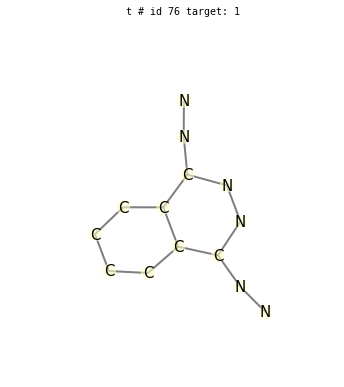

Graph id: 34


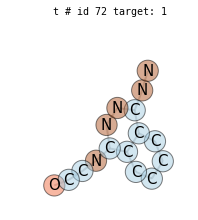

running 20 samplesteps over 2 samplers


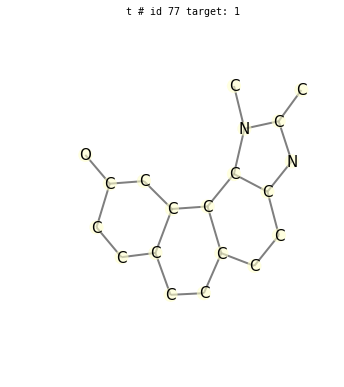

Graph id: 35


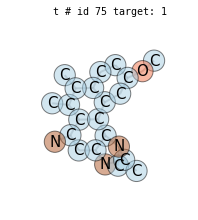

running 20 samplesteps over 2 samplers


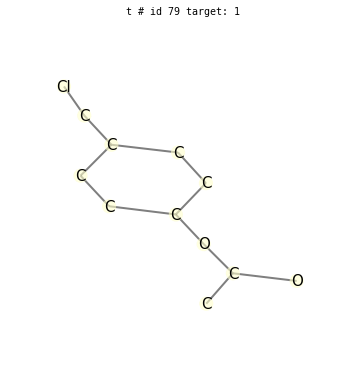

Graph id: 36


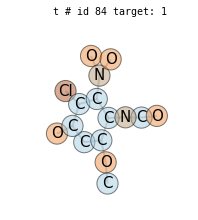

running 20 samplesteps over 2 samplers


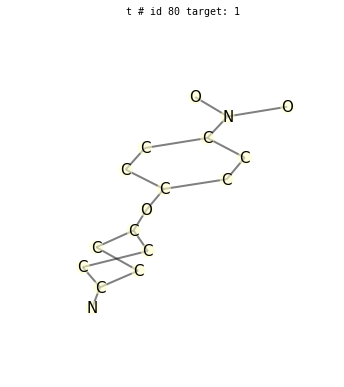

Graph id: 37


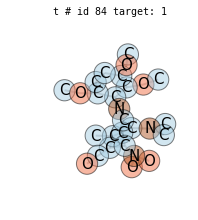

running 20 samplesteps over 2 samplers


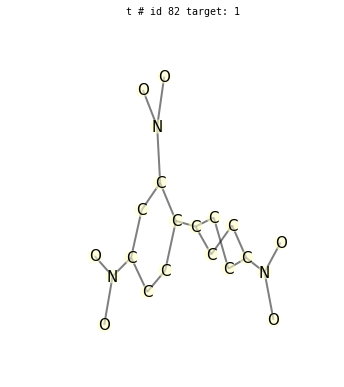

Graph id: 38


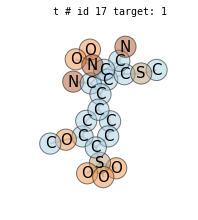

running 20 samplesteps over 2 samplers


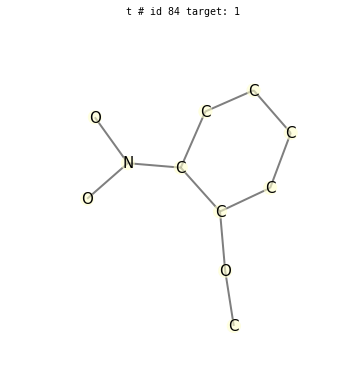

Graph id: 39


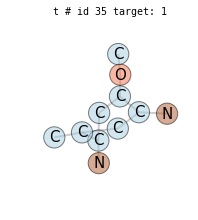

CPU times: user 3.8 s, sys: 120 ms, total: 3.92 s
Wall time: 4.28 s


In [6]:
%%time
# plot examples of sampling paths

# 2 drawing systems are available:
from graphlearn.utils import openbabel
from graphlearn.utils import draw

monitors=[]
ids=range(id_start,id_end)
for i,res in enumerate(results):
    print 'Graph id: %d'%(ids[i])
    monitors.append(res[1])
    #scores.append(res[1].sampling_info['score_history'])
    
    graphlist=res[0]
    draw.graphlearn(graphlist,contract=False,#vertex_label='id',
                   n_graphs_per_line=6, size=3, 
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='_labels_',
                   vertex_alpha=0.5, edge_alpha=0.2, node_size=450)
    
    # we use the fancy one
    #openbabel.draw(graphlist, d3=False, n_graphs_per_line=6,size=200)

In [7]:
scores=[]
for mon in monitors:
    scores_mon=[]
    for d in sorted(mon):
        
        scores_mon.append(d['score'][0])
    scores.append(scores_mon)
print scores
'''
    z=0
    scorelist=[]
    monitor=res[1]
    while True:
        if z in monitor:
            scorelist.append(monitor[z]['score'][0])
            z+=1
        else:
            break
    scores.append(scorelist) 
    '''

[[0.8365403872169499, 0.83874460269343643, 0.46420002227621782, 0.90578391061686436, 0.80588729425926164, 0.83874460269343643, 0.46420002227621782, 0.7499098989828924, 0.32325778127954419, 0.8365403872169499, 0.83174860223773517, 0.93388616481970332, 0.8350697069259001, 0.90578391061686436, 0.85484098219331905, 0.82530440685839979, 0.87498683585358217, 0.8350697069259001, 0.9075031819137096, 0.8365403872169499, 0.83174860223773517, 0.89183398249934243, 0.8365403872169499, 0.93872553583316198], [0.25520636155241472, 0.74042134499391166, 0.63885751536692004, 0.7153473695747935, 0.25520636155241494, 0.71311422497250043, 0.51900666389838546, 0.7153473695747935, 0.47320225964688045, 0.64288405156212591, 0.73730817863015818, 0.64730454213714617, 0.63915378914452137, 0.53174522141414893, 0.6404842342280388, 0.64828267424550279, 0.32722589357075249, 0.63885751536692004, 0.69119625335550405, 0.64820375205353753, 0.51459644268765137, 0.69256429901162464, 0.67552679741459554, 0.74042134499391166]

"\n    z=0\n    scorelist=[]\n    monitor=res[1]\n    while True:\n        if z in monitor:\n            scorelist.append(monitor[z]['score'][0])\n            z+=1\n        else:\n            break\n    scores.append(scorelist) \n    "

# Show sample score history

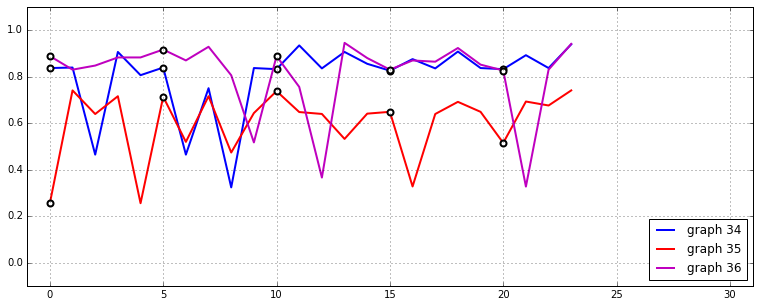

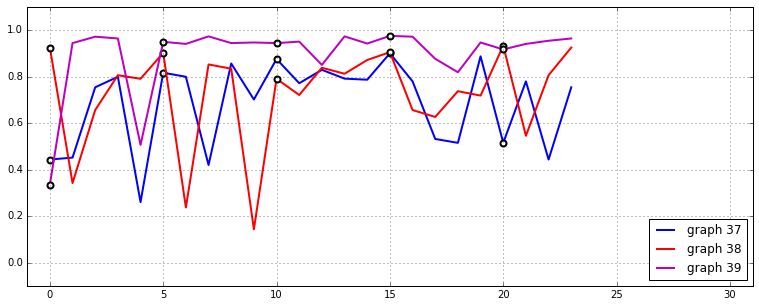

CPU times: user 284 ms, sys: 0 ns, total: 284 ms
Wall time: 281 ms


In [8]:
%%time
# plot sampling path score
from itertools import islice
import numpy as np
import pylab as plt
SUMSTEPS=30
markevery=5
step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):

    plt.figure(figsize=(13,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
     
        data = list(islice(score,None, None, step))
        plt.plot(data, linewidth=2, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
        plt.plot(data, linestyle='None',markevery=markevery, markerfacecolor='white', marker='o', markeredgewidth=2,markersize=6)
    plt.legend(loc='lower right')
    plt.grid()
    plt.xlim(-1,SUMSTEPS+1)
    plt.ylim(-0.1,1.1)
    plt.show()

---